In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIRECTORY = '/content/drive/MyDrive/Vegetable Image Dataset/Vegetable Images'

Epoch 1/10
----------
train Loss: 5609481658.1756 Acc: 0.0656
validation Loss: 2.7086 Acc: 0.0666
Epoch 2/10
----------
train Loss: 20.9089 Acc: 0.0630
validation Loss: 2.7082 Acc: 0.0666
Epoch 3/10
----------
train Loss: 21.7068 Acc: 0.0674
validation Loss: 2.7085 Acc: 0.0682
Epoch 4/10
----------
train Loss: 15.4682 Acc: 0.0617
validation Loss: 2.7085 Acc: 0.0682
Epoch 5/10
----------
train Loss: 57.3378 Acc: 0.0633
validation Loss: 2.7084 Acc: 0.0682
Epoch 6/10
----------
train Loss: 141.8528 Acc: 0.0639
validation Loss: 2.7085 Acc: 0.0666
Epoch 7/10
----------
train Loss: 7.2957 Acc: 0.0635
validation Loss: 2.7090 Acc: 0.0666
Epoch 8/10
----------
train Loss: 3.4607 Acc: 0.0662
validation Loss: 2.7088 Acc: 0.0666
Epoch 9/10
----------
train Loss: 2.7762 Acc: 0.0649
validation Loss: 2.7089 Acc: 0.0666
Epoch 10/10
----------
train Loss: 2.7871 Acc: 0.0651
validation Loss: 2.7084 Acc: 0.0666
Best validation Acc: 0.068220


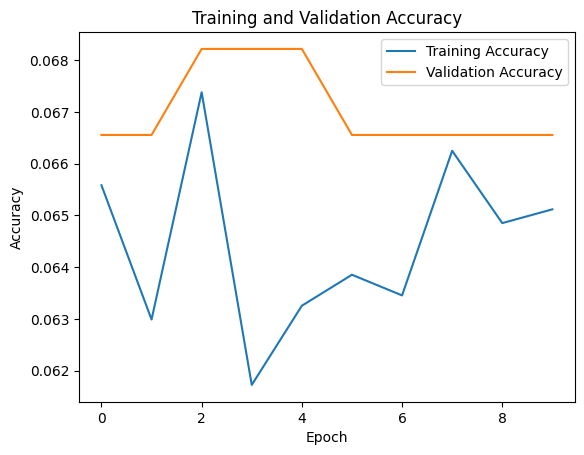

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

Test Accuracy: 0.0667
Precision: 0.0044
Recall: 0.0667
F1 Score: 0.0083
Mean Loss: 2.7084
              precision    recall  f1-score   support

        Bean       0.00      0.00      0.00       200
Bitter_Gourd       0.00      0.00      0.00       200
Bottle_Gourd       0.00      0.00      0.00       200
     Brinjal       0.00      0.00      0.00       200
    Broccoli       0.00      0.00      0.00       200
     Cabbage       0.00      0.00      0.00       200
    Capsicum       0.00      0.00      0.00       200
      Carrot       0.00      0.00      0.00       200
 Cauliflower       0.00      0.00      0.00       200
    Cucumber       0.00      0.00      0.00       200
      Papaya       0.00      0.00      0.00       200
      Potato       0.07      1.00      0.12       200
     Pumpkin       0.00      0.00      0.00       200
      Radish       0.00      0.00      0.00       200
      Tomato       0.00      0.00      0.00       200

    accuracy                           0.07 

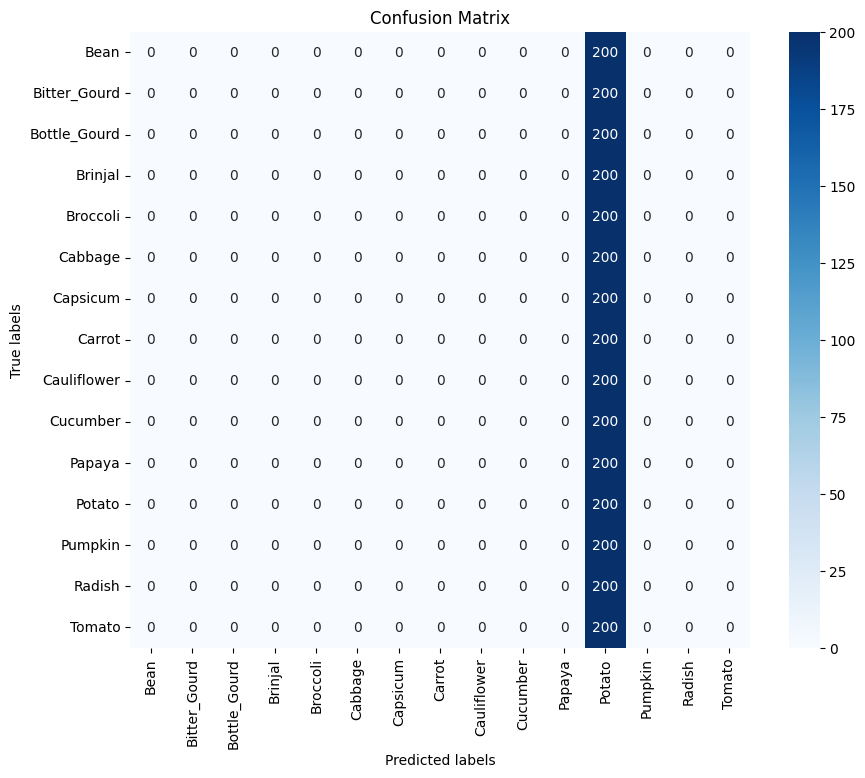

In [ ]:
BATCH_SIZE = 64
NUM_WORKERS = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

def load_datasets():
    return {x: datasets.ImageFolder(os.path.join(DATA_DIRECTORY, x), data_transforms[x]) for x in ['train', 'validation', 'test']}

def create_dataloaders(image_datasets):
    return {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'validation', 'test']}

def setup_model():
    model = models.vgg16(pretrained=False)
    for param in model.parameters():
        param.requires_grad = True
    num_output_classes = len(image_datasets['train'].classes)
    model.classifier[6] = nn.Sequential(
        nn.Linear(4096, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, num_output_classes)
    )
    return model.to(device)

def train_model(model, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
            else:
                val_acc_history.append(epoch_acc.item())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        if val_acc_history[-1] > best_acc:
            best_acc = val_acc_history[-1]

    print('Best validation Acc: {:4f}'.format(best_acc))

    plt.plot(range(len(train_acc_history)), train_acc_history, label='Training Accuracy')
    plt.plot(range(len(val_acc_history)), val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            loss = criterion(outputs, labels)
            losses.append(loss.item())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mean_loss = np.mean(losses)

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Mean Loss: {mean_loss:.4f}')

    print(classification_report(y_true, y_pred, target_names=image_datasets['test'].classes))

    return y_true, y_pred

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

image_datasets = load_datasets()
dataloaders = create_dataloaders(image_datasets)
model = setup_model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_model(model, criterion, optimizer, num_epochs=10)

y_true, y_pred = evaluate_model(model, dataloaders['test'])

conf_matrix = confusion_matrix(y_true, y_pred)
class_names = image_datasets['test'].classes
plot_confusion_matrix(conf_matrix, class_names)